# Support Vector Machines

## Linear SVM
* You can think of an SVM classifier as fitting the
widest possible street (represented by the parallel dashed lines) between the classes.
This is called large margin classification.
* ![](etc/largeMarginClassification.jpg)
* Notice that adding more training instances “off the street” will not affect the decision
boundary at all: it is fully determined (or “supported”) by the instances located on the
edge of the street. These instances are called the support vectors (they are circled in
Figure)
* In Scikit-Learn’s SVM classes, you can control this balance using the C hyperparame‐
ter: a smaller C value leads to a wider street but more margin violations

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # Irıs-Virginica
print(X[:5])
print(y[:5])

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]
[0. 0. 0. 0. 0.]


In [3]:
svm_clf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('linear_svd', LinearSVC(C=1, loss='hinge')),
    ]
)
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svd', LinearSVC(C=1, loss='hinge'))])

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

* Alternatively, you could use the SVC class, using SVC(kernel="linear", C=1), but it
is much slower, especially with large training sets, so it is not recommended. Another
option is to use the SGDClassifier class, with SGDClassifier(loss="hinge",
alpha=1/(m*C)). This applies regular Stochastic Gradient Descent to
train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it
can be useful to handle huge datasets that do not fit in memory (out-of-core training), or to handle online classification tasks
* The LinearSVC class regularizes the bias term, so you should center
the training set first by subtracting its mean. This is automatic if
you scale the data using the StandardScaler. Moreover, make sure
you set the loss hyperparameter to "hinge", as it is not the default
value. Finally, for better performance you should set the dual
hyperparameter to False, unless there are more features than
training instances (we will discuss duality later in the chapter)

* Although linear SVM classifiers are efficient and work surprisingly well in many
cases, many datasets are not even close to being linearly separable. One approach to
handling nonlinear datasets is to add more features, such as polynomial features in some cases this can result in a linearly separable dataset.
* Consider the left plot in Figure below: it represents a simple dataset with just one feature x1.
This dataset is not linearly separable, as you can see. But if you add a second feature x2 = (x1)^2, the resulting 2D dataset is perfectly linearly separable.
* ![](etc/featureAdding.jpg)

In [5]:
import matplotlib.pyplot as plt
X, y = datasets.make_moons(n_samples=100, noise=0.2)
X.shape, y.shape

((100, 2), (100,))

In [6]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline(
    [
        ('poly_features', PolynomialFeatures(degree=4)),
        ('scaler', StandardScaler()),
        ('svm_clf', LinearSVC(C=10, loss='hinge'))
    ]
)

polynomial_svm_clf.fit(X, y.ravel())

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

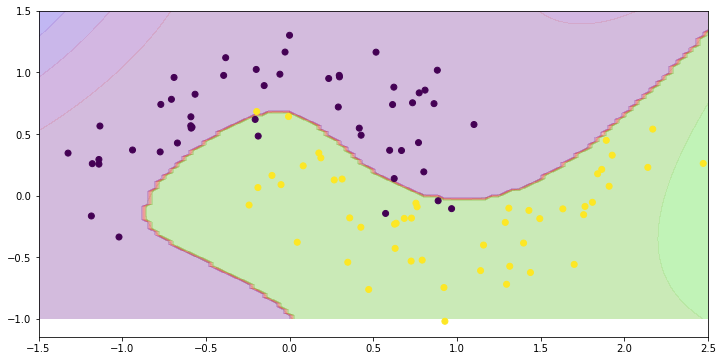

In [7]:
def plot_dataset(X, y, figsize=None):
    if figsize:
        plt.figure(figsize=(12, 6))
    plt.scatter(X[:,0], X[:,1], c=y)

def plot_predictions(clf, axes, figsize=None):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    if figsize:
        plt.figure(figsize=(12, 6))
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5], figsize=(12, 6))
plot_dataset(X, y)

plt.show()




## Polynomial Kernel

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataset(X, y, figsize=None):
    if figsize:
        plt.figure(figsize=(12, 6))
    plt.scatter(X[:,0], X[:,1], c=y)

def plot_predictions(clf, axes, figsize=None):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    if figsize:
        plt.figure(figsize=(12, 6))
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

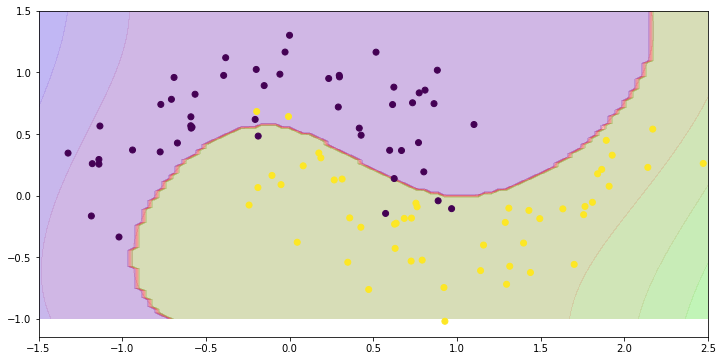

In [9]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
    ]
)
poly_kernel_svm_clf.fit(X, y)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5], figsize=(12, 6))
plot_dataset(X, y)

## Adding Similarity Features

* Another technique to tackle nonlinear problems is to add features computed using a
similarity function that measures how much each instance resembles a particular
landmark. For example, let’s take the one-dimensional dataset discussed earlier and
add two landmarks to it at x1= –2 and x1= 1. Next,
let’s define the similarity function to be the Gaussian Radial Basis Function (RBF)
with γ = 0.3
* ![](etc/gaussianRBF.jpg)
* It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at
the landmark). Now we are ready to compute the new features. For example, let’s look
at the instance x1= –1: it is located at a distance of 1 from the first landmark, and 2
from the second landmark. Therefore its new features are x2 = exp (–0.3 × 12) ≈ 0.74
and x3= exp (–0.3 × 22) ≈ 0.30. The plot on the right of Figure below shows the transformed dataset (dropping the original features). As you can see, it is now linearly
separable.
* ![](etc/gaussianRBF2.jpg)
* You may wonder how to select the landmarks. The simplest approach is to create a
landmark at the location of each and every instance in the dataset. This creates many
dimensions and thus increases the chances that the transformed training set will be
linearly separable. The downside is that a training set with m instances and n features
gets transformed into a training set with m instances and m features (assuming you
drop the original features). If your training set is very large, you end up with an
equally large number of features

Just like the polynomial features method, the similarity features method can be useful
with any Machine Learning algorithm, but it may be computationally expensive to
compute all the additional features, especially on large training sets. However, once
again the kernel trick does its SVM magic: it makes it possible to obtain a similar
result as if you had added many similarity features, without actually having to add
them

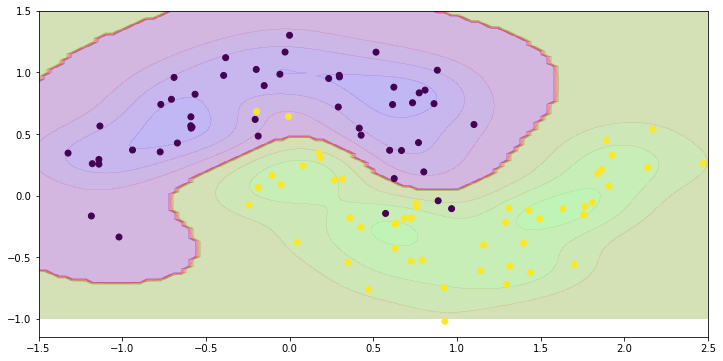

In [10]:
rbf_kernel_svm_clf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svc_clf', SVC(kernel='rbf', gamma=5, C=0.01))
    ]
)
rbf_kernel_svm_clf.fit(X, y)
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5], figsize=(12, 6))
plot_dataset(X, y)

* γ (gamma) acts like a regularization
hyperparameter: if your model is overfitting, you should reduce it, and if it is underfitting, you should increase it (similar to the C hyperparameter)
* ![](etc/gaussianRBF3.jpg)

## SVM Regression
* As we mentioned earlier, the SVM algorithm is quite versatile: not only does it support linear and nonlinear classification, but it also supports linear and nonlinear
regression. The trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression
tries to fit as many instances as possible on the street while limiting margin violations.

In [11]:
m = 50

np.random.seed(42)

X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [12]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [13]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)

svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

* The following code produces the model represented on the left of Figure below using
Scikit-Learn’s SVR class (which supports the kernel trick). The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent
of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when
the training set grows large (just like the SVC class).
* ![](etc/polySVR.jpg)

In [14]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')